In [2]:
CUDA_INDEX = 5
NAME = 'AIDS-groups'

In [3]:
import sys
sys.path.insert(0, '../..')
sys.path.insert(0, '../../pyged/lib')

In [4]:
import os
import pickle
import random
import time

import IPython as ipy
import matplotlib.pyplot as plt
import numpy as np
import torch
torch.cuda.set_device(CUDA_INDEX)
torch.backends.cudnn.benchmark = True
import torch.optim
import torch_geometric as tg
import torch_geometric.data
from tqdm.auto import tqdm

from neuro import config, datasets, metrics, models, train, utils, viz
import pyged

from importlib import reload
reload(config)
reload(datasets)
reload(metrics)
reload(models)
reload(pyged)
reload(train)
reload(utils)
reload(viz)

<module 'neuro.viz' from '../../neuro/viz.py'>

In [5]:
preds = [
    ('NeuroGSim     ', torch.load(f'../preds/{NAME}/outer_pred.pt', map_location='cpu')),
#     ('NeuroGSim-NN  ', torch.load(f'../preds/{NAME}/nn_outer_pred.pt', map_location='cpu')),
#     ('NeuroGSim-Dual', torch.load(f'../preds/{NAME}/dual_outer_pred.pt', map_location='cpu')),
    ('H2MN-RW        ', torch.as_tensor(np.load(f'../preds/{NAME}/h2mn_rw_outer.npy'))),
    ('H2MN-NE        ', torch.as_tensor(np.load(f'../preds/{NAME}/h2mn_ne_outer.npy'))),
    ('SimGNN        ', torch.as_tensor(np.load(f'../preds/{NAME}/sg_outer_pred.npy'))),
    ('Branch        ', torch.load(f'../preds/{NAME}/b_outer_pred.pt', map_location='cpu')),
    ('F2            ', torch.load(f'../preds/{NAME}/f2_outer_pred.pt', map_location='cpu')),
]

In [6]:
outer_test_set = torch.load(f'/data/rishabh/neurosim/final/data/AIDS/outer_groups.pt', map_location='cpu')
queries, _, lb, ub = outer_test_set

In [6]:
for label, pred in preds:
    Y = metrics.auroc_at_range(torch.tensor([1]), lb, ub, pred)
    Z = utils.nanmean(Y, dim=-1)
    print(f'{Z.item()*100:.2f}')

94.27
84.39
85.30
84.47
98.75


In [8]:
def range_metrics(fn, lb, ub, preds, ylabel, title, percent=True):
    r = torch.arange(1, int(torch.max(lb).item()), 1)
    plt.figure()
    Ys = []
    for label, pred in preds:
        Y = fn(r, lb, ub, pred)
        viz.plot_summary(r, Y, show_std=False, label=label, lim=percent)
        Ys.append((Y, label))
    plt.legend()
    plt.xlabel('range')
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()

    for Y, label in Ys:
#         print(f'{label}', end='\n')
        Z = utils.nanmean(Y, dim=-1)
        for i in [1,5,10,15,20]:
            if percent:
                print(f'{Z[(i*Z.shape[0]//100+1)-1].item()*100:.2f}', end=' / ' if i != 20 else '\n')
            else:
                print(f'{Z[(i*Z.shape[0]//100+1)-1].item()*100:.2f}', end=' / ' if i != 20 else '\n')
#         print()

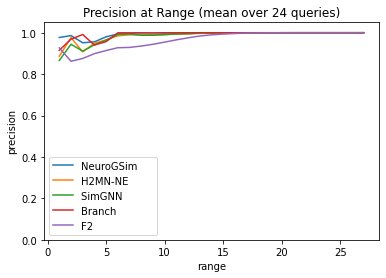

97.68 / 98.62 / 95.14 / 98.02 / 99.38
88.60 / 97.68 / 90.77 / 96.56 / 98.51
86.60 / 94.42 / 91.10 / 96.39 / 99.14
91.51 / 96.87 / 99.12 / 95.71 / 99.96
92.67 / 86.22 / 87.55 / 91.40 / 92.76


In [8]:
range_metrics(metrics.precision_at_range, lb, ub, preds,
              'precision', f'Precision at Range (mean over {len(queries)} queries)')

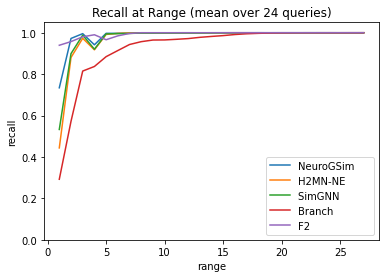

73.40 / 97.23 / 99.55 / 99.70 / 99.70
44.38 / 88.03 / 97.30 / 99.16 / 99.67
53.29 / 89.90 / 98.83 / 99.42 / 99.58
29.23 / 57.20 / 81.48 / 88.44 / 91.39
93.94 / 95.71 / 98.03 / 96.61 / 98.49


In [9]:
range_metrics(metrics.recall_at_range, lb, ub, preds,
              'recall', f'Recall at Range (mean over {len(queries)} queries)')

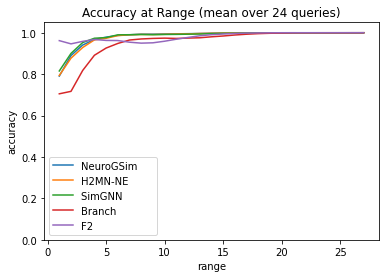

79.05 / 88.98 / 94.06 / 97.85 / 98.70
79.36 / 87.71 / 92.85 / 97.30 / 98.61
81.52 / 90.01 / 95.26 / 97.66 / 98.97
70.50 / 71.68 / 81.79 / 92.60 / 94.82
96.17 / 94.62 / 95.82 / 96.28 / 96.22


In [10]:
range_metrics(metrics.accuracy_at_range, lb, ub, preds,
              'accuracy', f'Accuracy at Range (mean over {len(queries)} queries)')

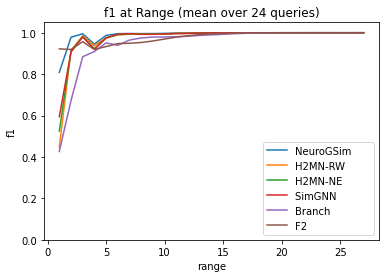

80.84 / 97.81 / 99.50 / 98.70 / 99.53
44.75 / 91.36 / 98.51 / 97.48 / 98.95
52.50 / 91.15 / 98.13 / 97.54 / 99.03
59.44 / 90.65 / 97.91 / 97.44 / 99.34
42.65 / 67.18 / 88.40 / 95.10 / 93.90
92.20 / 91.90 / 95.67 / 93.31 / 94.77


In [9]:
range_metrics(metrics.f1_at_range, lb, ub, preds,
              'f1', f'f1 at Range (mean over {len(queries)} queries)')

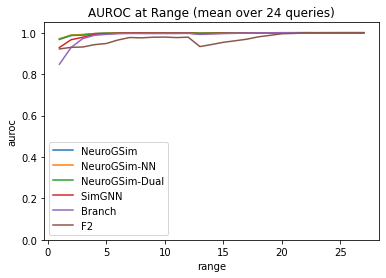

96.94 / 98.71 / 99.05 / 99.74 / 99.70
97.07 / 98.84 / 99.14 / 99.78 / 99.82
96.75 / 98.68 / 98.80 / 99.77 / 99.78
92.87 / 96.62 / 97.82 / 99.49 / 99.76
84.78 / 92.90 / 97.18 / 99.21 / 99.53
92.16 / 92.93 / 93.11 / 94.79 / 96.48


In [11]:
range_metrics(metrics.auroc_at_range, lb, ub, preds,
              'auroc', f'AUROC at Range (mean over {len(queries)} queries)')

# 